# 🌸 CNN Flower Classifier for New Dataset

This notebook builds, trains, and evaluates a Convolutional Neural Network (CNN) to classify flower images from the new dataset.

**Key Steps:**
1.  **Setup:** Import libraries and define configurations.
2.  **Data Loading & Inspection:** Load the dataset and visualize class distributions.
3.  **Preprocessing & Augmentation:** Prepare data for training using `ImageDataGenerator`.
4.  **Visualization:** Display sample augmented images.
5.  **CNN Modeling:** Define, compile, and train the CNN model.
6.  **Evaluation:** Analyze training history, classification reports, and confusion matrices.
7.  **Prediction:** Make predictions on the test set.
8.  **Submission:** Save the results in the required format.

In [2]:
# 1) Import Libraries and Set Seeds
import os
import json
import math
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

print(f"TensorFlow: {tf.__version__}")
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Optional: enable GPU memory growth if GPU is present
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs detected and memory growth enabled: {len(gpus)}")
    else:
        print("No GPU detected, using CPU")
except Exception as e:
    print("GPU setup note:", e)

TensorFlow: 2.20.0
No GPU detected, using CPU


In [3]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.20.0
Built with CUDA: False
GPU devices: []


In [4]:
# 2) Configuration and Paths
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
EPOCHS = 30
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.2
SEED = 42

# Paths for the new dataset
BASE_DIR = "archive/dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VALID_DIR = os.path.join(BASE_DIR, "valid")
TEST_DIR = os.path.join(BASE_DIR, "test")
CAT_TO_NAME_JSON = "archive/cat_to_name.json"

MODELS_DIR = "models"
Path(MODELS_DIR).mkdir(parents=True, exist_ok=True)

print({
    'BATCH_SIZE': BATCH_SIZE,
    'IMG_SIZE': IMG_SIZE,
    'EPOCHS': EPOCHS,
    'LEARNING_RATE': LEARNING_RATE,
    'VALIDATION_SPLIT': VALIDATION_SPLIT,
    'TRAIN_DIR': TRAIN_DIR,
    'VALID_DIR': VALID_DIR,
    'TEST_DIR': TEST_DIR
})

{'BATCH_SIZE': 32, 'IMG_SIZE': (224, 224), 'EPOCHS': 30, 'LEARNING_RATE': 0.0001, 'VALIDATION_SPLIT': 0.2, 'TRAIN_DIR': 'archive/dataset\\train', 'VALID_DIR': 'archive/dataset\\valid', 'TEST_DIR': 'archive/dataset\\test'}


In [5]:
# 3) Load Class Names
with open(CAT_TO_NAME_JSON, 'r') as f:
    cat_to_name = json.load(f)

# The training directory contains folders named '1', '2', etc.
# We map these to the actual flower names.
class_names = [cat_to_name[str(i)] for i in sorted([int(d) for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])]
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print("First 5 class names:", class_names[:5])

Number of classes: 102
First 5 class names: ['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 'english marigold']


Total training images: 6552 | Imbalance ratio: 7.63


C:\Users\Ammad\AppData\Local\Temp\ipykernel_18116\3512667547.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=counts, palette='viridis')


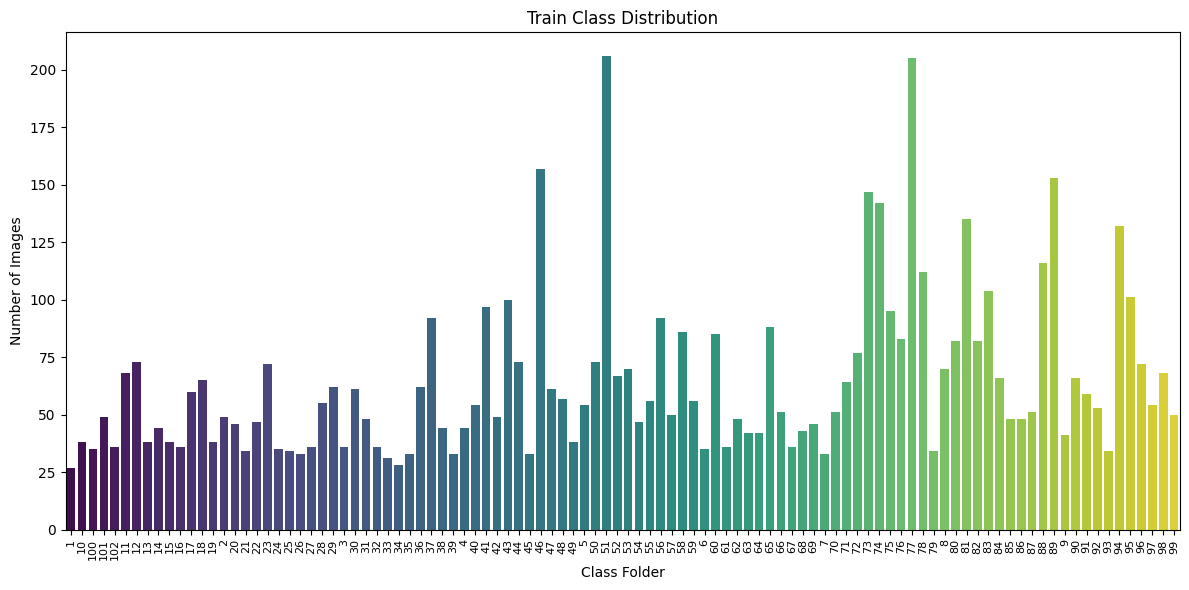

In [6]:
# 4) Inspect Dataset and Class Distribution (Train)
from collections import defaultdict

class_counts = {}
for class_folder in sorted(os.listdir(TRAIN_DIR)):
    class_path = os.path.join(TRAIN_DIR, class_folder)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('jpg','jpeg','png'))])
        class_counts[class_folder] = count

if not class_counts:
    raise RuntimeError(f"No class folders found in {TRAIN_DIR}. Ensure train data is in subfolders per class.")

counts = np.array(list(class_counts.values()))
imbalance_ratio = counts.max() / max(1, counts.min())

print(f"Total training images: {counts.sum()} | Imbalance ratio: {imbalance_ratio:.2f}")

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=counts, palette='viridis')
plt.title('Train Class Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Class Folder')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

In [7]:
# 5) Data Augmentation & Generators

# Get class directories and sort them numerically to ensure consistent mapping
class_dirs = sorted(os.listdir(TRAIN_DIR), key=int)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True, # Added vertical flip
    brightness_range=[0.7, 1.3], # Added brightness range
    fill_mode='nearest'
)

# Note: No augmentation on validation data, only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=class_dirs,  # Enforce correct order
    shuffle=True
)

validation_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=class_dirs,  # Enforce correct order
    shuffle=False
)

# Test generator will be created later for prediction
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

print(f"Train samples: {train_generator.samples} | Validation samples: {validation_generator.samples}")
print("Class indices mapping (first 5):", {k: v for k, v in list(class_indices.items())[:5]})

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.
Train samples: 6552 | Validation samples: 818
Class indices mapping (first 5): {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}
Found 818 images belonging to 102 classes.
Train samples: 6552 | Validation samples: 818
Class indices mapping (first 5): {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}


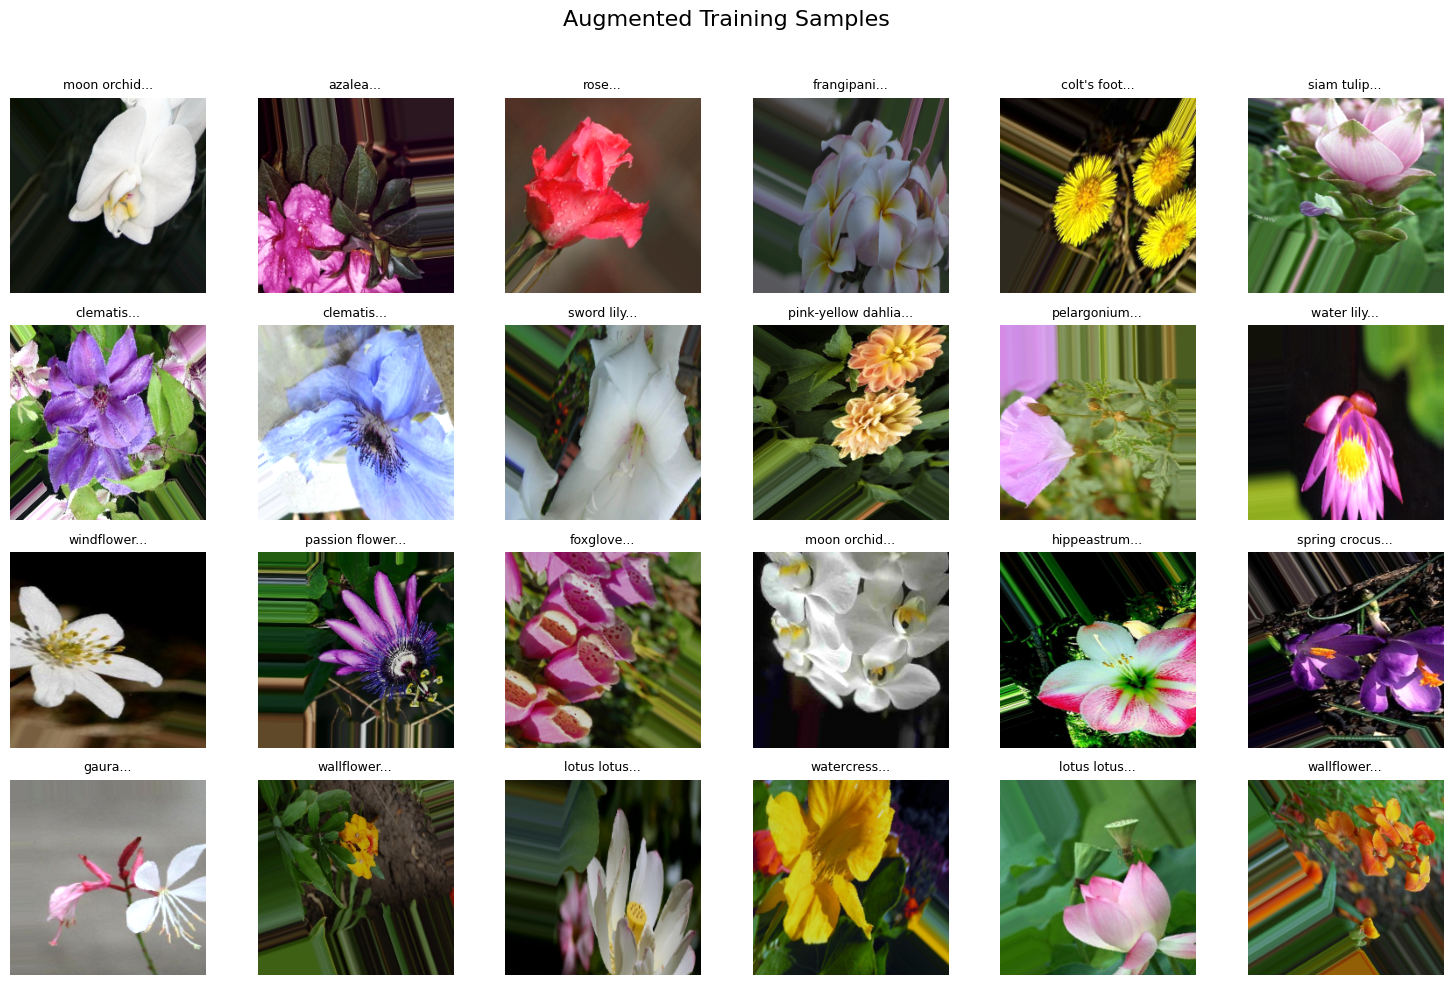

In [11]:
# 6) Visualize Augmented Samples
images, labels = next(train_generator)
rows, cols = 4, 6
plt.figure(figsize=(cols * 2.5, rows * 2.5))
for i in range(rows * cols):
    if i >= len(images):
        break
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    class_idx = np.argmax(labels[i])
    folder_name = idx_to_class[class_idx]
    flower_name = cat_to_name.get(folder_name, "Unknown")
    plt.title(f"{flower_name[:20]}...", fontsize=9)
    plt.axis("off")
plt.suptitle("Augmented Training Samples", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# 6.1) Compute Class Weights
from sklearn.utils.class_weight import compute_class_weight

# Get class indices from the training generator
cls_indices, cls_counts = np.unique(train_generator.classes, return_counts=True)

# Calculate class weights
weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=cls_indices,
    y=train_generator.classes
)

class_weights = {int(c): float(w) for c, w in zip(cls_indices, weights_arr)}

# Print the calculated weights for verification
print('Class weights (aligned with generator indices):')
for c_idx, weight in class_weights.items():
    folder_name = idx_to_class[c_idx]
    flower_name = cat_to_name.get(folder_name, "Unknown")
    print(f"- {flower_name}: {weight:.3f}")

Class weights (aligned with generator indices):
- pink primrose: 2.379
- globe thistle: 1.690
- blanket flower: 1.835
- trumpet creeper: 1.311
- blackberry lily: 1.784
- snapdragon: 0.945
- colt's foot: 0.880
- king protea: 1.690
- spear thistle: 1.460
- yellow iris: 1.690
- globe-flower: 1.784
- purple coneflower: 1.071
- peruvian lily: 0.988
- balloon flower: 1.690
- hard-leaved pocket orchid: 1.311
- giant white arum lily: 1.396
- fire lily: 1.889
- pincushion flower: 1.367
- fritillary: 0.892
- red ginger: 1.835
- grape hyacinth: 1.889
- corn poppy: 1.947
- prince of wales feathers: 1.784
- stemless gentian: 1.168
- artichoke: 1.036
- canterbury bells: 1.784
- sweet william: 1.053
- carnation: 1.338
- garden phlox: 1.784
- love in the mist: 2.072
- mexican aster: 2.294
- alpine sea holly: 1.947
- ruby-lipped cattleya: 1.036
- cape flower: 0.698
- great masterwort: 1.460
- siam tulip: 1.947
- sweet pea: 1.460
- lenten rose: 1.190
- barbeton daisy: 0.662
- daffodil: 1.311
- sword lil

: 

In [ ]:
# 7) Define Deeper CNN Architecture
def build_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=num_classes):
    L2 = keras.regularizers.l2(1e-5)
    model = keras.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(32, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        # Block 2
        layers.Conv2D(64, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(128, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        
        # Block 4
        layers.Conv2D(256, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, 3, padding='same', use_bias=False, kernel_regularizer=L2),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),

        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu', kernel_regularizer=L2),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = build_cnn()
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 112, 112, 64)   │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 56, 56, 128)    │             

 Total params: 1,359,046 (5.18 MB)

 Trainable params: 1,357,126 (5.18 MB)

 Non-trainable params: 1,920 (7.50 KB)

: 

In [ ]:
# 8) Compile CNN Model
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
cnn_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=5, name='top5_acc')]
)

: 

In [ ]:
# 9) Train CNN with Callbacks and Class Weights
checkpoint_path = os.path.join(MODELS_DIR, 'cnn_new_dataset_best.keras')
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True), # Increased patience
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1), # Lower min_lr
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1),
]
 
history = cnn_model.fit(
    train_generator,
    epochs=50, # Increased epochs
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights, # Apply class weights
    verbose=1,
)

print('Training complete. Best model saved at:', checkpoint_path)

c:\Users\Ammad\Documents\Projects\Personal\UEL\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 59/205 ━━━━━━━━━━━━━━━━━━━━ 8:05 3s/step - accuracy: 0.0156 - loss: 4.9988 - top5_acc: 0.0748

KeyboardInterrupt: 

: 

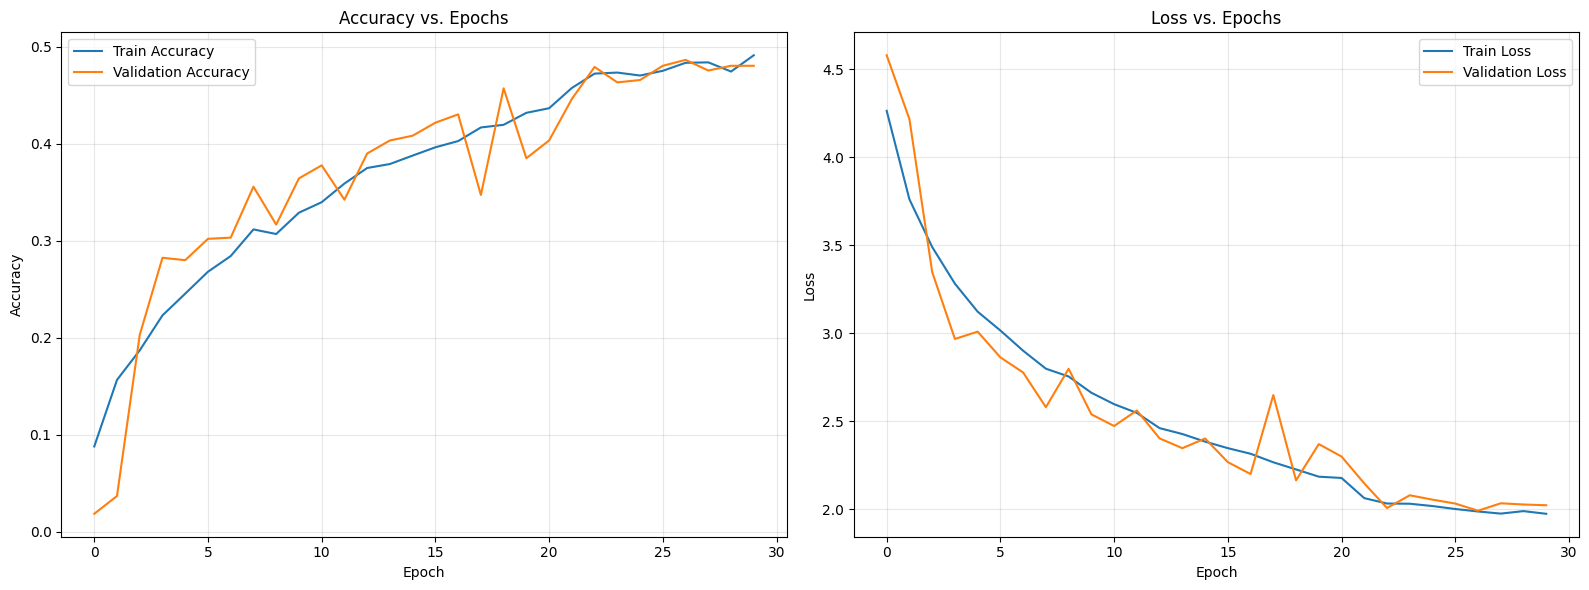

: 

In [ ]:
# 10) Plot Training Curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy vs. Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss vs. Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step
Validation Accuracy: 0.48655256723716384
\nClassification Report:
                           precision    recall  f1-score   support

            pink primrose       0.50      0.12      0.20         8
            globe thistle       0.50      0.25      0.33         4
           blanket flower       0.75      0.50      0.60         6
          trumpet creeper       1.00      0.20      0.33         5
          blackberry lily       0.75      0.50      0.60         6
               snapdragon       0.00      0.00      0.00        10
              colt's foot       0.36      1.00      0.53         5
              king protea       0.22      0.40      0.29         5
            spear thistle       0.33      1.00      0.50         1
              yellow iris       0.50      0.14      0.22         7
             globe-flower       1.00      0.50      0.67         2
        purple coneflower       0.86      0.38      0.52        16
            peruvian 

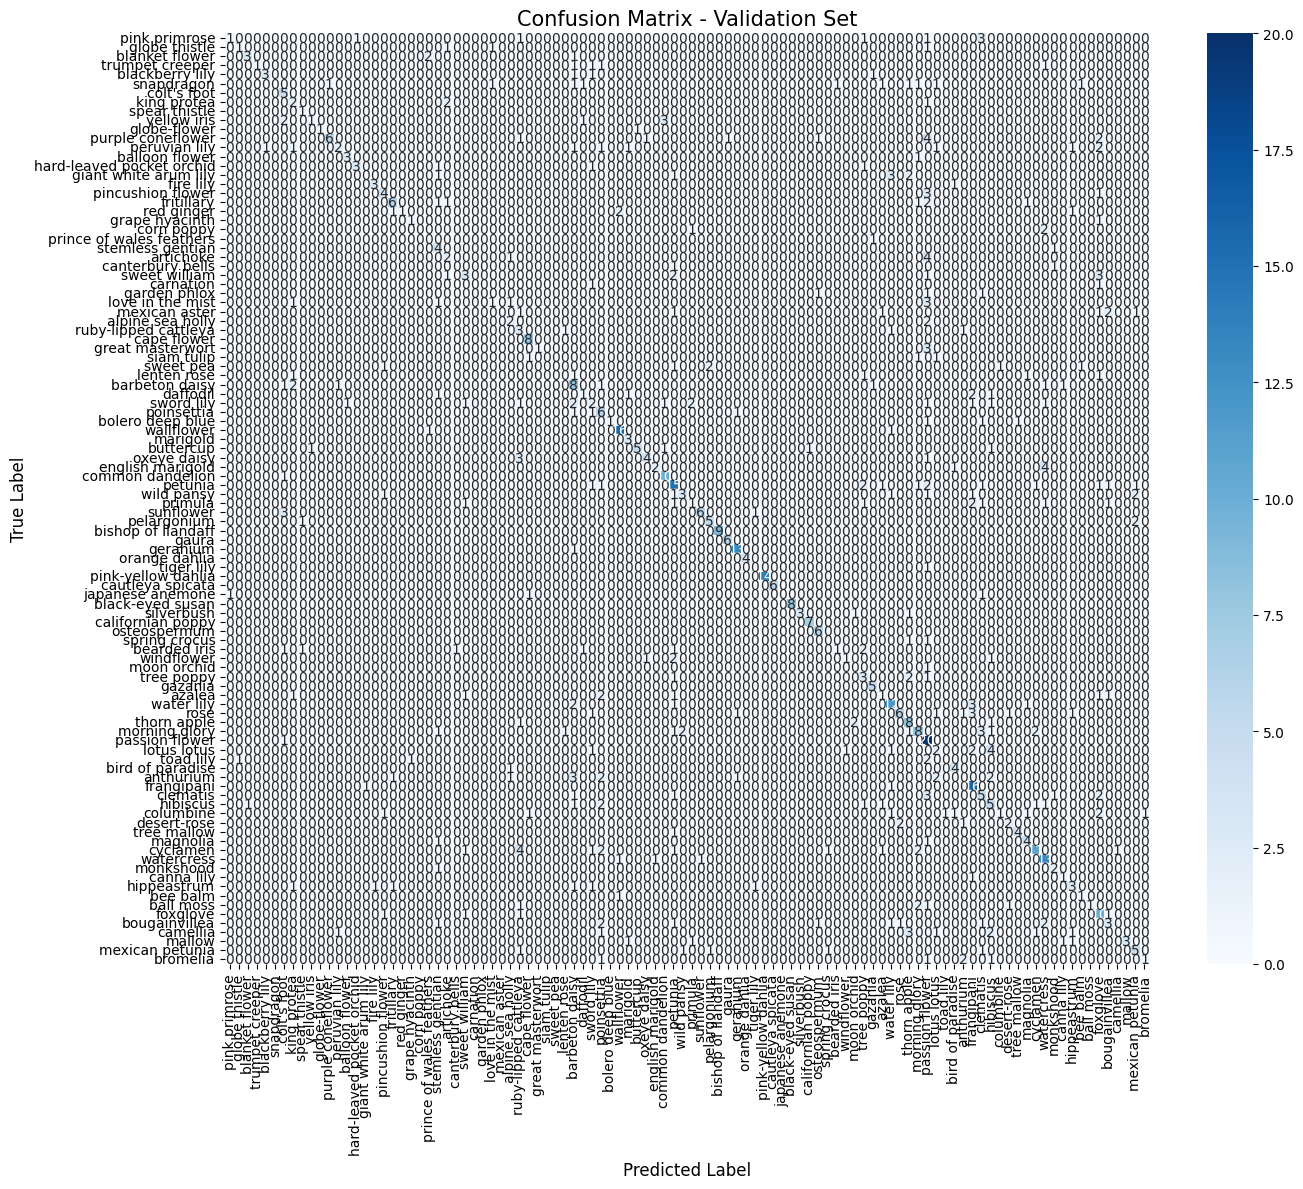

: 

In [ ]:
# 11) Validation Evaluation: Classification Report & Confusion Matrix
# Load best model
best_model = tf.keras.models.load_model(checkpoint_path)

# Predict on validation set
validation_generator.reset()
val_steps = int(np.ceil(validation_generator.samples / validation_generator.batch_size))
val_probs = best_model.predict(validation_generator, steps=val_steps, verbose=1)
val_pred_idx = np.argmax(val_probs, axis=1)
val_true_idx = validation_generator.classes

# Get class names in order
ordered_class_names = [cat_to_name[idx_to_class[i]] for i in range(num_classes)]

print('Validation Accuracy:', np.mean(val_pred_idx == val_true_idx))
print('\\nClassification Report:')
print(classification_report(val_true_idx, val_pred_idx, target_names=ordered_class_names, zero_division=0))

cm = confusion_matrix(val_true_idx, val_pred_idx)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=ordered_class_names, yticklabels=ordered_class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Validation Set', fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# 12) Prepare Test Data and Predict
# The test directory contains image files directly, so we'll create a tf.data.Dataset manually.
test_image_paths = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

if not test_image_paths:
    raise ValueError(f"No images found in {TEST_DIR}")

def load_and_preprocess_test_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    return img

test_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_ds = test_ds.map(load_and_preprocess_test_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Predict
test_probs = best_model.predict(test_ds, verbose=1)
test_pred_idx = np.argmax(test_probs, axis=1)

# Map predictions to class names
pred_class_names = [ordered_class_names[i] for i in test_pred_idx]
test_filenames = [os.path.basename(p) for p in test_image_paths]

print(f"Predicted on {len(test_filenames)} test images.")
print("Sample predictions:", pred_class_names[:5])

26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step
Predicted on 819 test images.
Sample predictions: ['passion flower', 'passion flower', 'passion flower', 'passion flower', 'passion flower']


: 

Submission file saved to: flower_submission_new_dataset.csv


C:\Users\Ammad\AppData\Local\Temp\ipykernel_14404\378652552.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=pred_class_names, palette='viridis', order=submission_df['prediction'].value_counts().index)


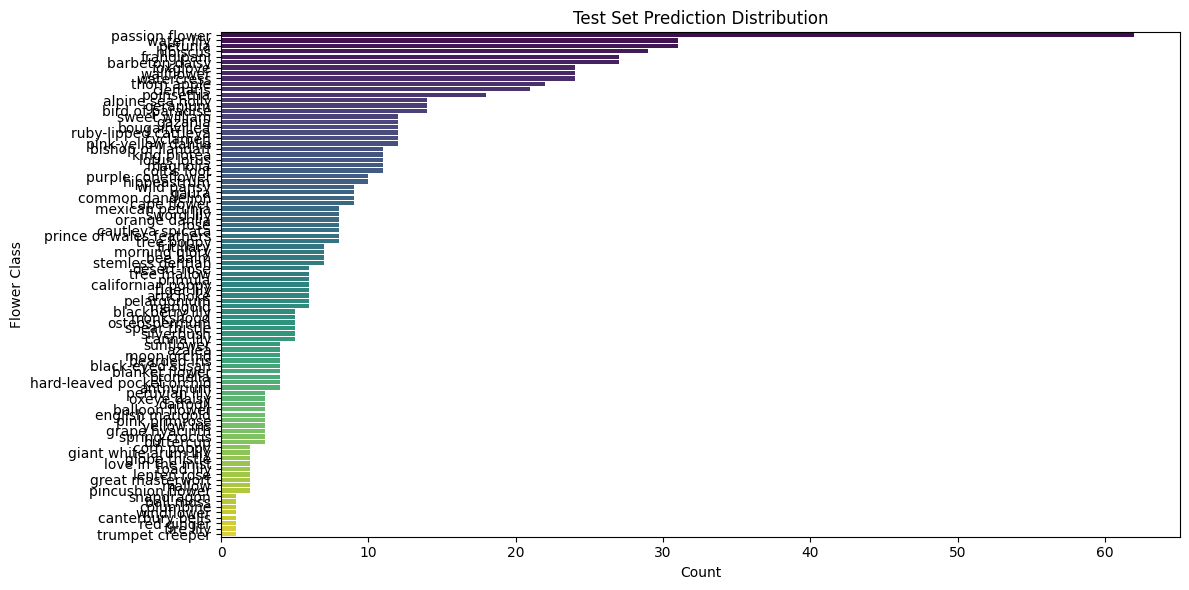

: 

In [ ]:
# 13) Save Submission and Visualize Predictions
# Create submission dataframe
submission_df = pd.DataFrame({
    'filename': [os.path.basename(f) for f in test_filenames],
    'prediction': pred_class_names
})

# Save to CSV
submission_path = 'flower_submission_new_dataset.csv'
submission_df.to_csv(submission_path, index=False)
print(f"Submission file saved to: {submission_path}")

# Visualize prediction distribution
plt.figure(figsize=(12, 6))
sns.countplot(y=pred_class_names, palette='viridis', order=submission_df['prediction'].value_counts().index)
plt.title('Test Set Prediction Distribution')
plt.xlabel('Count')
plt.ylabel('Flower Class')
plt.tight_layout()
plt.show()